# Miniproject 1 - Classification
## Classification, weight sharing, auxiliary losses

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective.

### 0. Import library and define python3 as default

In [1]:
#!/usr/bin/env python3
""" File to solve the first miniproject which is classification """

import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F
import dlc_practical_prologue as prologue


__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

### 1. Import and Process data

In [2]:
def import_data(N, normalize):
    """Function to import dataset from prologue"""
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

    # Normalize data
    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_classes, train_target, test_input, test_classes, test_target

In [3]:
def to_one_hot(tensor):
    one_hot = torch.zeros((tensor.size(0), 10)).type(torch.FloatTensor)
    one_hot[list(range(0,tensor.size(0))), tensor] = 1
    return one_hot

In [4]:
def split_data_validation(data, device, size=200):
    """Function to split the data into up and down categories with also validation set."""
    rnd = []
    up, down = 0, 1
    valid_idx = []
    train_idx = list(range(0, data.input.size(0)))
    
    for i in range(size):
        rnd = random.randint(0, len(train_idx)-1)
        valid_idx.append(train_idx.pop(rnd))
    
    # Create class variables to well store all the data
    data_up = DataStoredValid(data.input[train_idx, up, :, :].reshape(len(train_idx), 1, data.input.size(2), data.input.size(3)).to(device),
                              to_one_hot(data.classes[train_idx, up]).to(device),
                              data.target[train_idx].to(device),
                              data.input[valid_idx, up, :, :].reshape(len(valid_idx), 1, data.input.size(2), data.input.size(3)).to(device),
                              to_one_hot(data.classes[valid_idx, up]).to(device),
                              data.target[valid_idx].to(device))
    
    data_down = DataStoredValid(data.input[train_idx, down, :, :].reshape(len(train_idx), 1, data.input.size(2), data.input.size(3)).to(device),
                                to_one_hot(data.classes[train_idx, down]).to(device),
                                data.target[train_idx].to(device),
                                data.input[valid_idx, down, :, :].reshape(len(valid_idx), 1, data.input.size(2), data.input.size(3)).to(device),
                                to_one_hot(data.classes[valid_idx, down]).to(device),
                                data.target[valid_idx].to(device))
    
    return data_up, data_down

### 2. Classes to well store data

In [5]:
class DataStored:
    """A class to well store data to have a cleaner code."""
    def __init__(self, data_in, classes, target):
        self.input = data_in
        self.classes = classes
        self.target = target


class DataStoredValid(DataStored):
    """"A class to well store data with validation set to have a cleaner code."""
    def __init__(self, data_in, classes, target, valid_input, valid_classes, valid_target):
        DataStored.__init__(self, data_in, classes, target)
        self.valid_input = valid_input
        self.valid_classes = valid_classes
        self.valid_target = valid_target

### 3. Define the device to work on CUDA if it is available

In [6]:
def define_device():
    """Check if cuda is available to run model on it."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
        
    print('\nDevice : {}'.format(device))
    
    return device

### 4. Define models

In [7]:
class Net_recognition(nn.Module):
    """Recognition model definition."""
    def __init__(self, nb_hidden):
        super(Net_recognition, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [8]:
class Net_compare(nn.Module):
    """Comparison model definition."""
    def __init__(self, nb_hidden):
        super(Net_compare, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5)
        self.fc1 = nn.Linear(4, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 1)

    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), kernel_size=3, stride=1))
        x = F.relu(self.fc1(x.view(-1, 4)))
        x = self.fc2(x)
        return x

### 5. Define training models

In [32]:
def train_model_recognition(model, criterion, data, e,
                            epochs = 25, mini_batch_size = 100, lr = 1e-1, verbose = 2):
    """Training recognition model."""
    eta = 1e-1
#    output_to_train = torch.zeros(dict_in['train_classes'].size(), dtype = torch.double)
    
    sum_loss = 0

    for b in range(0, data.input.size(0), mini_batch_size):
        output = model(data.input.narrow(0, b, mini_batch_size))
        loss = criterion(output, data.classes.narrow(0, b, mini_batch_size))

#        if e == epochs-1:
#            output_to_train[b:b+mini_batch_size, :] = output

        model.zero_grad()
        loss.backward()
        sum_loss += loss.item()

        for p in model.parameters():
            p.data.sub_(eta * p.grad.data)

    if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e+1, sum_loss), end = '\t\t\r')
    elif verbose == 1 and e%5 == 0: print(e+1, sum_loss)

    nb_errors = compute_nb_errors_recognition(model, data, mini_batch_size)
    return nb_errors#, output_to_train

In [33]:
def train_architecture(data, device, criterion, validation_size, nb_mid_error, nb_final_error,
                       repeat, r, epochs = 25, lr = 1e-1, verbose = 2):
    print('Run : {}'.format(r+1))
    
    # Define models
    model_recognition = Net_recognition(hidden_layer).to(device)
    model_compare = Net_compare(hidden_layer).to(device)
    
    # Process data
    data_up, data_down = split_data_validation(data, device, size=validation_size)
    
    for e in range(epochs):
        # Training models
        nb_mid_error[e, r] = train_model_recognition(model_recognition, criterion, data_up, e, verbose=verbose)
        nb_mid_error[e + epochs, r] = train_model_recognition(model_recognition, criterion, data_down, e, verbose=verbose)
        
        #nb_final_error = train_model_compare(model_compare, criterion, )

        # Dynamically adapt learning rate
        #dyn_lr = adapt_learning_rate(dyn_lr, loss, e)
    
    print('\n')
    return nb_mid_error, nb_final_error

In [11]:
def train_model_compare(model, criterion, input_data, target, epochs = 25, mini_batch_size = 100, lr = 1e-1, verbose = 2):
    """Training comparison model."""
    eta = 1e-1
    nb_errors = []
    
    for e in range(epochs):
        sum_loss = 0
        
        for b in range(0, input_data.size(0), mini_batch_size):
            output = model(input_data.narrow(0, b, mini_batch_size))
            loss = criterion(output, input_data.narrow(0, b, mini_batch_size))

            model.zero_grad()
            loss.backward()
            sum_loss += loss.item()

            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
                
        if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e+1, sum_loss), end = '\t\t\r')
        elif verbose == 1 and e%5 == 0: print(e+1, sum_loss)
        
        nb_errors.append(compute_nb_errors_compare(model, input_data, target, mini_batch_size))
    
    return nb_errors

### 6. Compute number of errors

In [12]:
def compute_nb_errors_recognition(model, data, mini_batch_size = 100):
    errors = 0

    for b in range(0, data.valid_input.size(0), mini_batch_size):
        output = model(data.valid_input.narrow(0, b, mini_batch_size))
        _, predicted = output.data.max(1)

        for k in range(mini_batch_size):
            if data.valid_classes.data[b + k, predicted[k]] <= 0:
                errors = errors + 1
    
    return errors*100/data.valid_classes.size(0)

In [13]:
def compute_nb_errors_compare(model, input_data, target, mini_batch_size = 100):
    errors = 0

    for b in range(0, input_data.size(0), mini_batch_size):
        output = model(input_data.narrow(0, b, mini_batch_size))
        _, predicted = output.data.max(1)

        for k in range(mini_batch_size):
            if target.data[b + k, predicted[k]] <= 0:
                errors = errors + 1
    
    return errors*100/target.size(0)

### 7. Usefull functions to improve learning

In [14]:
def adapt_learning_rate(learning_rate, loss, e):
    """Adapt the leaning rate: divide by two if oscillations are seen, multiply by two if a plateau is reached

    e: epochs
    """
    lst = loss[e - 50:e]
    
    if e > 50:
        # Decreases learning rate if high variation in the loss
        if loss[e] - loss[e - 1] - 0.5 > 0 and e > 5:
            learning_rate = learning_rate/2
            #optimizer = optim.SGD(model.parameters(), lr = learning_rate)
            #print('Decrease learning rate ',learning_rate)

        # Increases learning rate if a plateau is reached
        elif abs(sum(lst)/len(lst) - loss[e]) < 0.05:
            learning_rate = 2*learning_rate
            #optimizer = optim.SGD(model.parameters(), lr = learning_rate)
            #print('Increase learning rate ', learning_rate)
            
    return learning_rate

### 8. Plot results

In [52]:
def plot_results(errors, str_results):
    dim = 1
    xdata = np.arange(1, np.shape(errors)[0]+1)

    plt.figure(str_results)
    plt.title(str_results)
    plt.xlabel('Epochs [-]')
    plt.ylabel('Errors [%]')

    plt.plot(xdata, errors.mean(dim), 'r')
    plt.fill_between(xdata,
                     errors.mean(dim) - errors.std(dim),
                     errors.mean(dim) + errors.std(dim),
                     color='gray',
                     alpha=0.2)

    print("\n\nLast mean error : {}%".format(errors[-1].mean()))
    print("Last standard deviation : {}".format(errors[-1].std()))

### Main part


Device : cpu
Run : 1
Epoch: 25, loss: 0.20		

Run : 2
Epoch: 25, loss: 0.22		

Run : 3
Epoch: 25, loss: 0.21		

Run : 4
Epoch: 25, loss: 0.20		

Run : 5
Epoch: 25, loss: 0.21		



Last mean error : 10.2%
Last standard deviation : 1.8330302779823362


Last mean error : 9.2%
Last standard deviation : 1.2884098726725124


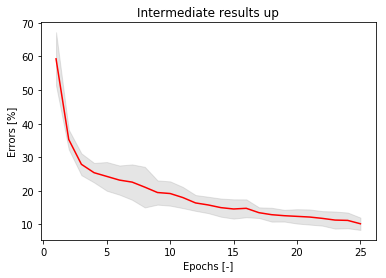

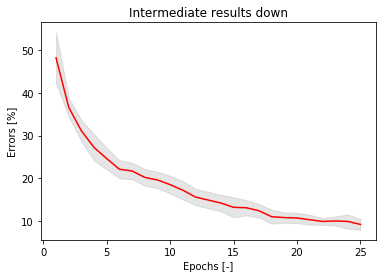

In [53]:
## Define variables
N, normalize = 1000, True
hidden_layer = 200
repeat, validation_size = 5, 200

epochs, mini_batch_size, dyn_lr, verbose = 25, 100, 1e-1, 0
device = define_device()
criterion = nn.MSELoss().to(device)

# Import data
train_input, train_classes, train_target, test_input, test_classes, test_target = import_data(N, normalize)
train_original = DataStored(train_input, train_classes, train_target)
test_original = DataStored(test_input, test_classes, test_target)

# Main process
nb_mid_error = np.zeros((2*epochs, repeat))
nb_final_error = np.zeros((epochs, repeat))

for r in range(repeat):
    nb_mid_error, nb_final_error = train_architecture(train_original, device, criterion, validation_size, nb_mid_error,
                                                      nb_final_error, repeat, r, epochs=epochs, verbose=verbose)

plot_results(nb_mid_error[:epochs, :], 'Intermediate results up')
plot_results(nb_mid_error[epochs:, :], 'Intermediate results down')
#plot_results(errors, str_results)